In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

from hypnotoad import tokamak
from hypnotoad.core.mesh import BoutMesh
from fusiondls import run_dls, file_read, file_write
from fusiondls.unpackConfigurationsMK import unpackConfigurationMK
from fusiondls.AnalyticCoolingCurves import LfuncKallenbach
from fusiondls.Profile import Profile



onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *

from code_comparison.solps_pp import *

from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline

%load_ext autoreload
%autoreload 2


# Read balance file

In [2]:
balance_paths = {
    # "SPR45" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-09-09 - STEP simulation for wide radiation front",
    # "V10" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-09-12 - Ryoko V10\step0_A5e21spr",
    "100MW_innerar_midplanepuff" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed_impomp_puff\step2_Xomp20_A8e21D0p4e24sp50r"
    }

select_case = "100MW_innerar_midplanepuff"


In [3]:
eqb = dict()


for case in balance_paths:
    side = "ol"
    eqb[case] = dict()
    eqb[case][side] = unpackConfigurationMK(File = os.path.join(balance_paths[case], "balance.nc"), Type = side, sepadd=2, resolution = 200, diagnostic_plot = False)
    
        
# file_write(eqb, "equilibrium.pkl")

# Read SOLPS case

In [4]:
store_slc = {}

for case in balance_paths:
    store_slc[case] = SOLPScase(balance_paths[case])
    store_slc[case].get_species()
    store_slc[case].get_impurity_stats("Ar", all_states = True)

Saving all states
Added total radiation, density and fraction for Ar


# Prepare cooling curves

In [12]:
T = np.linspace(0, 500, 1000)
curves = {}

## ADAS interpolated curves

Text(0.5, 1.0, 'Interpolated N curves')

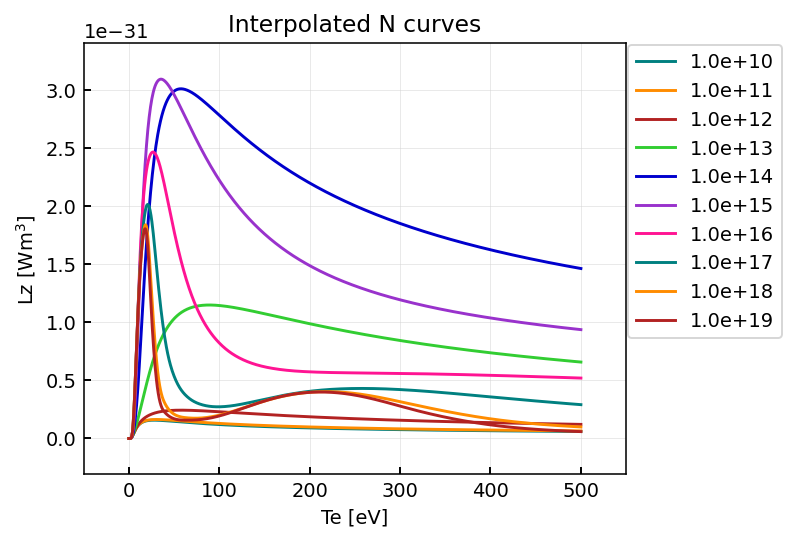

In [14]:
rd_N = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\nitrogen.nc")
rd_Ar = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc")

curves = {}
curves["Ar"] = {}

for netau in rd_Ar.coords["dim_ne_tau"].values:
    rate = rd_Ar["equilibrium_Lz"].sel(dim_ne_tau = netau, dim_electron_density=1e20, method="nearest")
    netau_name = netau
    curves["Ar"][netau_name] = sp.interpolate.interp1d(
        rd_Ar.coords["dim_electron_temp"].values, rate.values, kind = "cubic",
        fill_value = (rate.values[0], rate.values[-1]), bounds_error = False
        )


fig, ax = plt.subplots()
for netau in curves["Ar"].keys():
    ax.plot(T, [curves["Ar"][netau](x) for x in T], label = f"{netau:.1e}")
    
ax.legend(loc = "upper left", bbox_to_anchor=(1,1))
# ax.set_xlim(0,2)
# ax.set_ylim(0,1e-35)
# ax.set_yscale("log")
ax.set_xlabel("Te [eV]")
ax.set_ylabel("Lz [$Wm^{3}$]")
ax.set_title("Interpolated N curves")

## Synthetic and different species

(-10.0, 200.0)

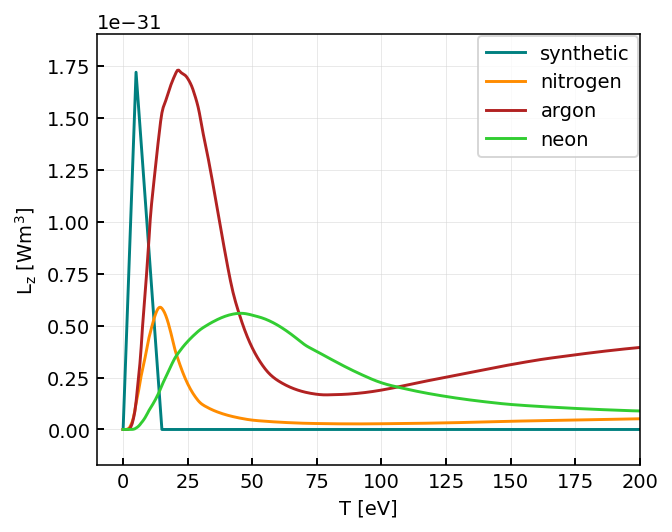

In [15]:
def LfuncArParametricTriShoulder(T, x1 = 0, x2 = 60, height = 0.5):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    
    x0 = 0
    y0 = 0
    # x1 = max_pos
    y1 = max
    # x2 = 
    y2 = max * height
    

    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    else:
        Lz = y2

    
    return Lz


curves["example"] = {
    "synthetic" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    # "wide" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 23, x2 = 50, height = 0),
    # "shoulder" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 23, x2 = 50, height = 0.27),
    "nitrogen" : lambda temp: LfuncKallenbach("N")(temp),
    "argon" : lambda temp: LfuncKallenbach("Ar")(temp),
    "neon" : lambda temp: LfuncKallenbach("Ne")(temp),
    
}
    
fig, ax = plt.subplots()


for name, function in curves["example"].items():
    ax.plot(T, [function(temp) for temp in T], lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel("$L_z$ [$W m^{3}$]")
ax.legend()
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlim(-10,200)


## Parametric curve scan

(-50.0, 300.0)

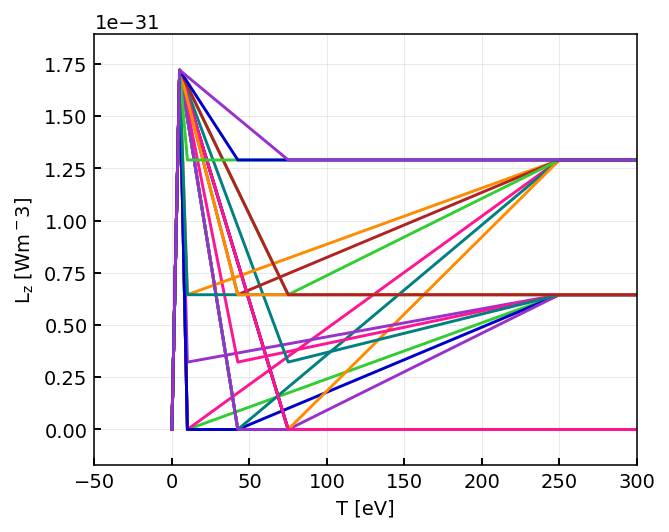

In [16]:
def LfuncArParametricTriShoulder(T, x1 = 0, x2 = 60, kink_fraction = 0.25, height = 0.5):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    
    x0 = 0
    y0 = 0
    x1 = 5
    y1 = max
    x2 = x2
    y2 = max * height * kink_fraction  # Kink height
    x3 = 250   # Last peak position
    y3 = max * height  # Final height
    x4 = 1000  # Final position
    
    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    elif T >= x2 and T < x3:
        Lz = (y2 * (x3 - T) + y3 * (T - x2)) / (x3 - x2)
    elif T >= x3 and T < x4:
        Lz = y3
    else:
        Lz = 0
    return Lz


curves["parametric"] = {}
x2_range = (10, 75)
kink_fraction_range = (0.5, 0.5)
height_range = (0, 0.75)
res = 3

# for kink_fraction in np.linspace(*kink_fraction_range, res):
for kink_fraction in [0, 0.5, 1]:
    for height in np.linspace(*height_range, res):
        for x2 in np.linspace(*x2_range, res):
            curves["parametric"][f"x2_{x2:.1f}_height_{height:.1f}_kinkfrac_{kink_fraction:.1f}"] =  \
            lambda temp, x2=x2, height=height, kink_fraction=kink_fraction: LfuncArParametricTriShoulder(temp, x1 = 23, x2 = x2, kink_fraction = kink_fraction, height = height)

fig, ax = plt.subplots()

# T = [50]
for name, function in curves["parametric"].items():
    ax.plot(T, [function(temp) for temp in T], lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel("$L_z$ [$W m^-3$]")
# ax.legend()
ax.set_xlim(None,300)

# Profiles

In [17]:
store_profiles = {}

## f_R

Text(0.5, 1.0, 'Flux expansion profiles')

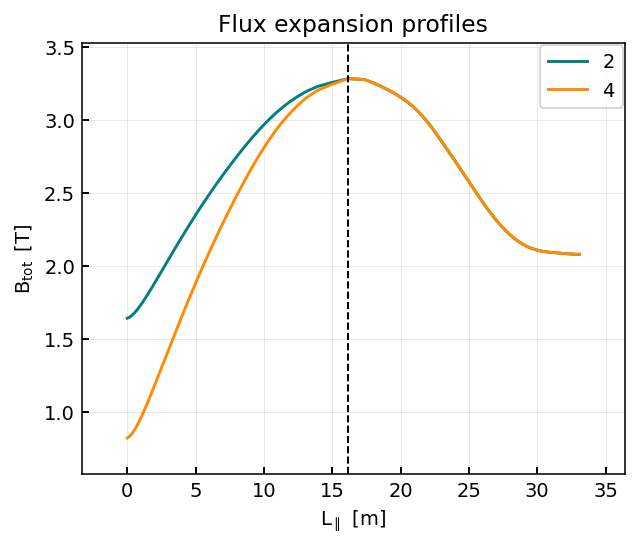

In [18]:
p = eqb[select_case]["ol"]

newp = Profile(p["R"], p["Z"], p["Xpoint"], p["Btot"], p["Bpol"], p["S"], p["Spol"], name = "base")

list_bxbt = [2, 4]
store_profiles["bxbt"] = {}

fig, ax = plt.subplots()

for bxbt in list_bxbt:
    store_profiles["bxbt"][bxbt] = copy.deepcopy(newp)
    store_profiles["bxbt"][bxbt].scale_BxBt(BxBt = bxbt)
    
    ax.plot(store_profiles["bxbt"][bxbt]["S"], store_profiles["bxbt"][bxbt]["Btot"], label = bxbt)
    
ylims = ax.get_ylim()
ax.vlines(newp["S"][newp["Xpoint"]], *ylims, color = "k", lw = 1.0, linestyle = "--")
ax.set_ylim(ylims)
ax.legend()
ax.set_xlabel("$L_{\parallel}\ \ [m]$")
ax.set_ylabel("$B_{tot}\ \ [T]$")
ax.set_title("Flux expansion profiles")

Text(0.5, 1.0, 'Flux expansion profiles')

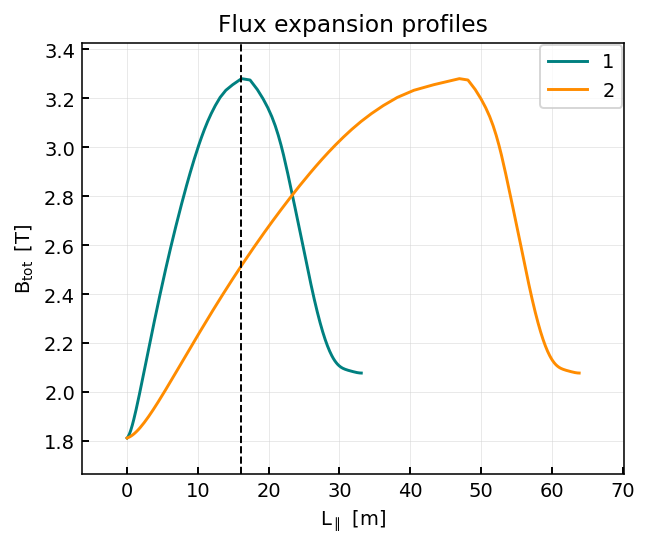

In [19]:
p = eqb[select_case]["ol"]

newp = Profile(p["R"], p["Z"], p["Xpoint"], p["Btot"], p["Bpol"], p["S"], p["Spol"], name = "base")

list_Lc_factors = [1, 2]
store_profiles["Lc"] = {}

fig, ax = plt.subplots()

for Lc_factor in list_Lc_factors:
    store_profiles["Lc"][Lc_factor] = copy.deepcopy(newp)
    store_profiles["Lc"][Lc_factor].scale_Lc(scale_factor = Lc_factor)
    
    ax.plot(store_profiles["Lc"][Lc_factor]["S"], store_profiles["Lc"][Lc_factor]["Btot"], label = Lc_factor)
    
ylims = ax.get_ylim()
ax.vlines(newp["S"][newp["Xpoint"]], *ylims, color = "k", lw = 1.0, linestyle = "--")
ax.set_ylim(ylims)
ax.legend()
ax.set_xlabel("$L_{\parallel}\ \ [m]$")
ax.set_ylabel("$B_{tot}\ \ [T]$")
ax.set_title("Flux expansion profiles")

# Parametric curve study

In [580]:
# set switches
radios_default = {
    "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
}

# set general run parameters
constants_default = {
    "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    "qpllu0": 1.35e9  ,  # heat flux density at the x point
    "nu": 1e19,  # Upstream density (if constant)
    "nu0": 1e19,  # Upstream density (if constant)
    "cz0": 0.045,  # Impurity fraction (if constant)
    "Lfunc": LfuncKallenbach("Ar"),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
}

stores = {}

## Run

In [ ]:
stores["curves"] = {}
constants_default["qpllu0"] = 3.325e9*0.01

for curve_name, function in curves["parametric"].items():
    stores["curves"][curve_name] = {}
    constants_default["Lfunc"] = function
    
    for param, profile in store_profiles["bxbt"].items():

        try: 
                out = run_dls(
                    constants = constants_default, 
                    radios = radios_default, 
                    d = profile,
                    SparRange = [0],
                    control_variable = "density",
                    verbosity = 0,
                    Ctol = 1e-3,
                    Ttol = 1e-3,
                    dynamicGrid = True,
                    dynamicGridRefinementRatio = 10,
                    dynamicGridRefinementWidth = 1)
                
                stores["curves"][curve_name][param] = copy.deepcopy(out)
            
        except KeyboardInterrupt:
            print("Stopped")
            sys.exit(0)
        print(param, curve_name)

KeyError: 'parametric'

## Capture front widths

In [444]:
## Get cases corresponding to fR=2
cases = {}
for curve_name, out in stores["curves"].items():
    cases[curve_name] = DLScase(out[2])

Text(0, 0.5, 'Cumulative radiation [W/W]')

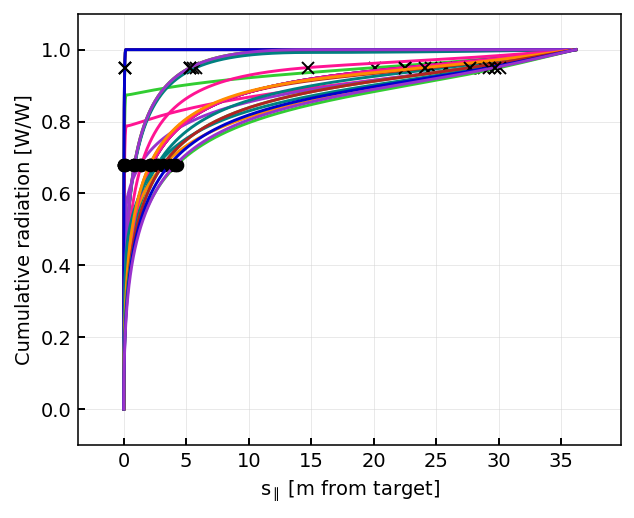

In [426]:
fig, ax = plt.subplots()

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, curve_name in enumerate(stores["curves"].keys()):
    case = cases[curve_name]
    df = case.data
    
    y = df["Prad_cum_norm"]
    
    ax.plot(df["Spar"], df["Prad_cum_norm"], label = curve_name)
    
    lower_threshold = 0.68
    ax.plot([case.get_radiation_location(lower_threshold)], [lower_threshold], "o", color = "k")
    
    upper_threshold = 0.95
    ax.plot([case.get_radiation_location(upper_threshold)], [upper_threshold], "x", color = "k")
    
ax.set_xlabel("$s_{\parallel}$ [m from target]")
ax.set_ylabel("Cumulative radiation [W/W]")
# ax.legend()

## Impact of front width on effects

In [21]:
scalings = pd.DataFrame()


### Calculate the threshold fraction (less than 1 for improvement)
for curve_name in stores["curves"].keys():

    profiles = store_profiles["bxbt"]
    store = stores["curves"][curve_name]
    names = list(store.keys())

    # Compare last and first case only!!
    df = get_detachment_scalings(profiles, store)
    df1 = DLScase(store[names[0]]).get_stats_dataframe()
    df2 = DLScase(store[names[-1]]).get_stats_dataframe()
    scaling = test_scalings(df1, df2)

    for col in scaling.columns:
        scalings.loc[curve_name,col] = scaling.loc[0, col]

scalings


NameError: name 'stores' is not defined

In [22]:
lowerthreshold = 0.68
upperthreshold = 0.50

df = scalings.copy()
for curve_name, store in stores["curves"].items():
    case = DLScase(store[list(store.keys())[0]])  # First case
    df.loc[curve_name, "front_width"] = case.get_front_width(0, 0.6)
    
fig, ax = plt.subplots()
style = dict(marker = "o", lw = 0)
ax.set_title(f"Correlation with front width")

# for col in ["Beff", "W_Tu", "curveclip", "upstream_rad"]:
for col in ["Beff"]:
    ax.plot(df["front_width"], df[col], **style, label = col)

ax.legend()
ax.set_xlabel("Front width [m parallel]")
ax.set_ylabel("Effect strength")

NameError: name 'stores' is not defined

# Example curve study

## Run BxBt

In [23]:
study = "curves_example_BxBt"

stores[study] = {}
constants_default["qpllu0"] = 3e8*1

for curve_name, function in curves["example"].items():
    
    # if curve_name == "thin":
    stores[study][curve_name] = {}
    constants_default["Lfunc"] = function
    
    for param, profile in store_profiles["bxbt"].items():

        try: 
                out = run_dls(
                    constants = constants_default, 
                    radios = radios_default, 
                    d = profile,
                    SparRange = [0],
                    control_variable = "density",
                    verbosity = 0,
                    Ctol = 1e-3,
                    Ttol = 1e-3,
                    dynamicGrid = True,
                    dynamicGridRefinementRatio = 100, dynamicGridRefinementWidth = 1,dynamicGridResolution = 3000,
                    # dynamicGridRefinementRatio = 10, dynamicGridRefinementWidth = 1,dynamicGridResolution = 500,
                    
                    dynamicGridDiagnosticPlot = False)
                
                stores[study][curve_name][param] = copy.deepcopy(out)
            
        except KeyboardInterrupt:
            print("Stopped")
            sys.exit(0)
        print(param, curve_name)

NameError: name 'stores' is not defined

## Run Lc

In [582]:
study = "curves_example_Lc"

stores[study] = {}
constants_default["qpllu0"] = 3.325e9*1

for curve_name, function in curves["example"].items():
    
    # if curve_name == "synthetic":
    stores[study][curve_name] = {}
    constants_default["Lfunc"] = function
    
    for param, profile in store_profiles["Lc"].items():

        try: 
                out = run_dls(
                    constants = constants_default, 
                    radios = radios_default, 
                    d = profile,
                    SparRange = [0],
                    control_variable = "density",
                    verbosity = 0,
                    Ctol = 1e-3,
                    Ttol = 1e-2,
                    dynamicGrid = True,
                    dynamicGridRefinementRatio = 100, dynamicGridRefinementWidth = 0.5, dynamicGridResolution = 6000,
                    dynamicGridDiagnosticPlot = False)
                
                stores[study][curve_name][param] = copy.deepcopy(out)
            
        except KeyboardInterrupt:
            print("Stopped")
            sys.exit(0)
        print(param, curve_name)

Solving...0.00...Complete in 0.5 seconds
1 synthetic
Solving...0.00...Complete in 0.5 seconds
2 synthetic
Solving...0.00...Complete in 4.5 seconds
1 nitrogen
Solving...0.00...Complete in 4.5 seconds
2 nitrogen
Solving...0.00...Complete in 4.6 seconds
1 argon
Solving...0.00...Complete in 4.9 seconds
2 argon
Solving...0.00...Complete in 4.5 seconds
1 neon
Solving...0.00...Complete in 4.2 seconds
2 neon


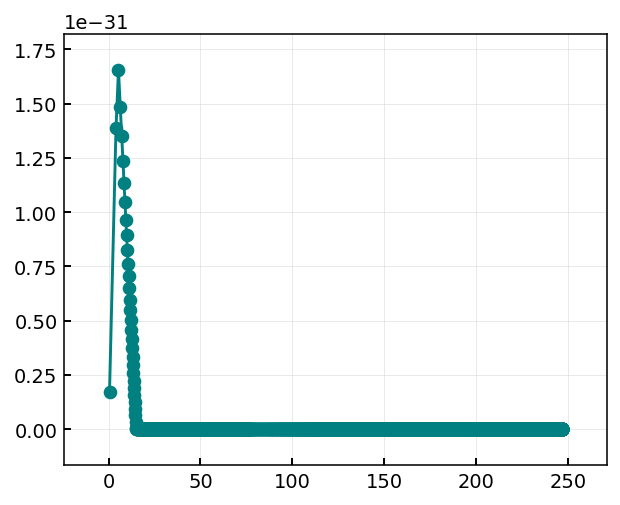

In [557]:
temp = np.linspace(0,50,100)

case = DLScase(stores[study]["synthetic"][2])
dls = case.data
s = case.stats

Te = dls["Te"]
Lz = [case.Lfunc(T) for T in Te]

fig, ax = plt.subplots()
ax.plot(Te, Lz, marker = "o")
# ax.plot(dls["Spar"], dls["Te"], marker = "o")
# ax.set_xscale("log")
# ax.set_xlim(-0.02,0.05)

## Plot fronts

In [435]:
stores[study][curve_name].keys()

dict_keys([2, 4])

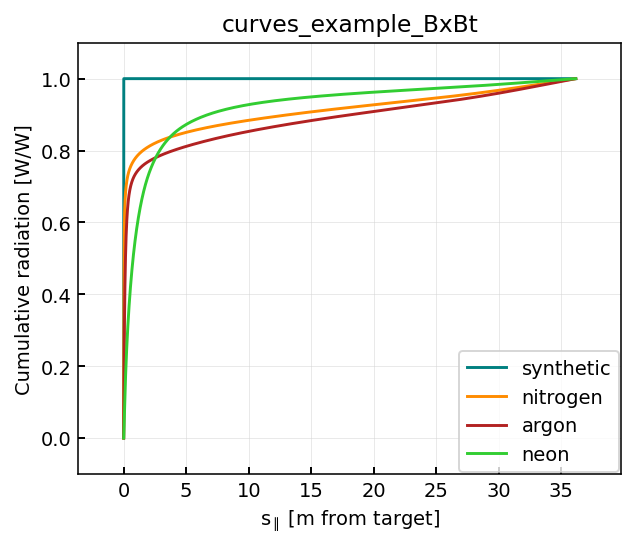

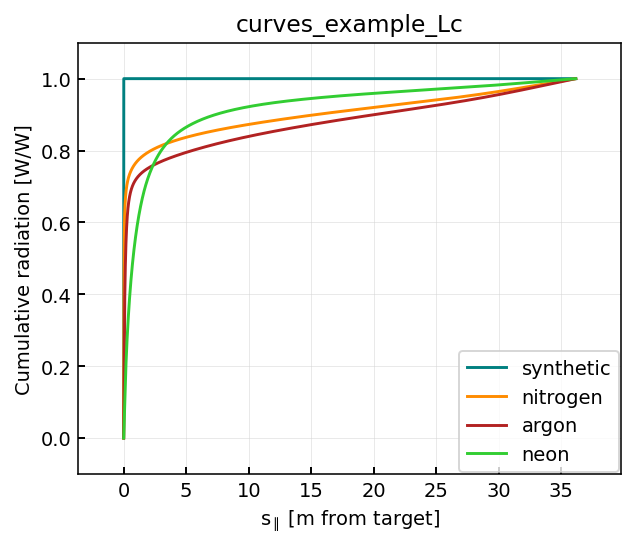

In [579]:
study = "curves_example_BxBt"

for study in ["curves_example_BxBt", "curves_example_Lc"]:

    fig, ax = plt.subplots()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for i, curve_name in enumerate(stores[study].keys()):
        first_name = list(stores[study][curve_name].keys())[0]
        case = DLScase(stores[study][curve_name][first_name])
        df = case.data
        y = df["Prad_cum_norm"]
        ax.plot(df["Spar"], df["Prad_cum_norm"], label = curve_name)
        
    ax.set_xlabel("$s_{\parallel}$ [m from target]")
    ax.set_ylabel("Cumulative radiation [W/W]")
    ax.legend()
    ax.set_title(study)

## Effect table: BxBt

In [532]:
# Compare last and first case only!!
store = stores[study]["synthetic"]
df1 = DLScase(store[2]).get_stats_dataframe()
df2 = DLScase(store[4]).get_stats_dataframe()
# scaling = test_scalings(df1, df2, "BxBt", cumulative = True)

display(df1)
display(df2)
# display(scaling)

,cvar,kappa0,Bf,Bx,Beff,BxBt,BxBteff,Lc,Wradial,avgB_ratio,int_qoverBsq_dt,W_Tu,W_Tu_simple,int_TLz_dt
0,3.104908e+20,2500.0,1.675803,3.351054,1.675806,1.999671,1.999667,8.385215,1.401666e+08,1.232678,7.077645,0.164516,0.341119,1.976159e+13


,cvar,kappa0,Bf,Bx,Beff,BxBt,BxBteff,Lc,Wradial,avgB_ratio,int_qoverBsq_dt,W_Tu,W_Tu_simple,int_TLz_dt
0,1.560760e+20,2500.0,0.837901,3.350812,0.837923,3.999053,3.99895,8.385215,1.401789e+08,1.39502,7.078094,0.168,0.344944,1.098828e+13


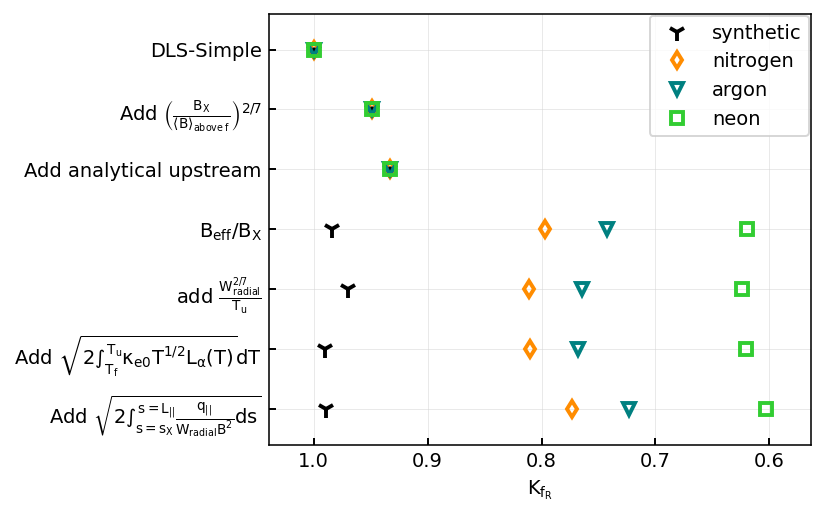

In [567]:
study = "curves_example_BxBt"

exponents = pd.DataFrame()

for curve_name in curves["example"].keys():
    # curve_name = "narrow"
    # curve_name = "shoulder"
    profiles = store_profiles["bxbt"]
    store = stores[study][curve_name]
    names = list(store.keys())

    # Compare last and first case only!!
    df1 = DLScase(store[names[0]]).get_stats_dataframe()
    df2 = DLScase(store[names[-1]]).get_stats_dataframe()
    scaling = test_scalings(df1, df2, "BxBt", cumulative = True)

    for col in scaling.drop(["result", "param_ratio"], axis = 1).columns:
        exponents.loc[curve_name, col] = (np.log(1/scaling[col]) / np.log(scaling["param_ratio"])).values[0]


fig, ax = plt.subplots()

dfplot = exponents[["simple_noavg_B", "simple", "abovex", "Beff", "W_Tu", "curveclip", "upstream_rad"]].copy()

labels = dict(simple_noavg_B = "DLS-Simple", 
              simple = r"Add $\left(\frac{B_X}{\langle B \rangle_{above\ f}}\right)^{2/7}$",
              abovex = "Add analytical upstream", 
              Beff = "$B_{eff}/B_{X}$",
              W_Tu = r"add $\frac{W_{radial}^{2/7}}{T_{u}}$",
              curveclip = r"Add ${\sqrt{2\int^{T_{u}}_{T_{f}} \kappa_{e0} T^{1/2}  L_{\alpha}(T) }dT}$", 
              upstream_rad = r"Add $\sqrt{2 \int^{s=L_{||}}_{s=s_{X}} \frac{q_{||}}{W_{radial}B^{2}}ds}$")

dfplot.rename(columns = labels, inplace = True)

curve_styles = dict(
    synthetic = dict(marker = "1", ms = 9, markeredgewidth = 2, c = "black", markerfacecolor = "None"),
    thin = dict(marker = "1", ms = 9, markeredgewidth = 2, markerfacecolor = "None"),
    wide = dict(marker = "2", ms = 9, markeredgewidth = 2),
    shoulder = dict(marker = "x", ms = 7, markeredgewidth = 2),
    argon = dict(marker = "v", ms = 6, markeredgewidth = 2, markerfacecolor = "None"),
    nitrogen = dict(marker = "d", ms = 6, markeredgewidth = 2, c = "darkorange", markerfacecolor = "None"),
    neon = dict(marker = "s", ms = 6, markeredgewidth = 2, c = "limegreen", markerfacecolor = "None")
)

for curve in dfplot.index:
    ax.plot(dfplot.loc[curve,:], dfplot.columns, lw = 0, label = curve, **curve_styles[curve])
    
ax.set_xlabel(r"$K_{f_R}$")
ax.invert_yaxis()
ax.invert_xaxis()
ax.legend()


## Effect table: Lc

In [564]:
# Compare last and first case only!!
df1 = DLScase(store[names[0]]).get_stats_dataframe()
df2 = DLScase(store[names[-1]]).get_stats_dataframe()
scaling = test_scalings(df1, df2, "Lc", cumulative = True)

display(df1)
display(df2)
display(scaling)

,cvar,kappa0,Bf,Bx,Beff,BxBt,BxBteff,Lc,Wradial,avgB_ratio,int_qoverBsq_dt,W_Tu,W_Tu_simple,int_TLz_dt
0,1.152841e+20,2500.0,1.812409,3.35163,2.192295,1.849268,1.528823,8.385215,1.404676e+08,1.209124,7.016206,0.167324,0.340673,2.208207e+12


,cvar,kappa0,Bf,Bx,Beff,BxBt,BxBteff,Lc,Wradial,avgB_ratio,int_qoverBsq_dt,W_Tu,W_Tu_simple,int_TLz_dt
0,8.375825e+19,2500.0,1.812409,3.351578,2.098345,1.849239,1.597248,16.662238,1.404035e+08,1.209185,7.101211,0.133626,0.309664,2.060615e+12


,result,param_ratio,simple_noavg_B,simple,abovex,Beff,W_Tu,curveclip,upstream_rad
0,0.726538,1.987097,0.821866,0.821878,0.747068,0.870036,0.764393,0.713302,0.721944


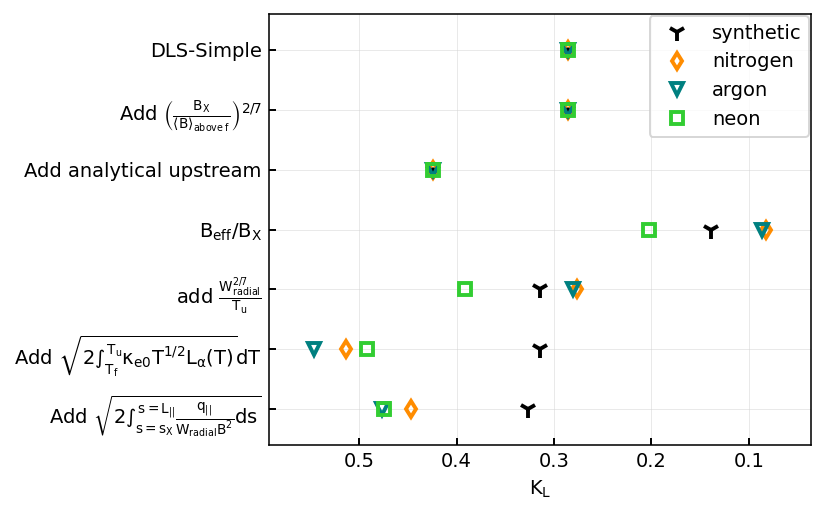

In [569]:
study = "curves_example_Lc"

exponents = pd.DataFrame()

for curve_name in curves["example"].keys():
    # curve_name = "narrow"
    # curve_name = "shoulder"
    profiles = store_profiles["Lc"]
    store = stores[study][curve_name]
    names = list(store.keys())

    # Compare last and first case only!!
    df1 = DLScase(store[names[0]]).get_stats_dataframe()
    df2 = DLScase(store[names[-1]]).get_stats_dataframe()
    scaling = test_scalings(df1, df2, "Lc", cumulative = True)

    for col in scaling.drop(["result", "param_ratio"], axis = 1).columns:
        exponents.loc[curve_name, col] = (np.log(1/scaling[col]) / np.log(scaling["param_ratio"])).values[0]
        
exponents


fig, ax = plt.subplots()

dfplot = exponents[["simple_noavg_B", "simple", "abovex", "Beff", "W_Tu", "curveclip", "upstream_rad"]].copy()

labels = dict(simple_noavg_B = "DLS-Simple", 
              simple = r"Add $\left(\frac{B_X}{\langle B \rangle_{above\ f}}\right)^{2/7}$",
              abovex = "Add analytical upstream", 
              Beff = "$B_{eff}/B_{X}$",
              W_Tu = r"add $\frac{W_{radial}^{2/7}}{T_{u}}$",
              curveclip = r"Add ${\sqrt{2\int^{T_{u}}_{T_{f}} \kappa_{e0} T^{1/2}  L_{\alpha}(T) }dT}$", 
              upstream_rad = r"Add $\sqrt{2 \int^{s=L_{||}}_{s=s_{X}} \frac{q_{||}}{W_{radial}B^{2}}ds}$")

dfplot.rename(columns = labels, inplace = True)

curve_styles = dict(
    synthetic = dict(marker = "1", ms = 9, markeredgewidth = 2, c = "black", markerfacecolor = "None"),
    thin = dict(marker = "1", ms = 9, markeredgewidth = 2, markerfacecolor = "None"),
    wide = dict(marker = "2", ms = 9, markeredgewidth = 2),
    shoulder = dict(marker = "x", ms = 7, markeredgewidth = 2),
    argon = dict(marker = "v", ms = 6, markeredgewidth = 2, markerfacecolor = "None"),
    nitrogen = dict(marker = "d", ms = 6, markeredgewidth = 2, c = "darkorange", markerfacecolor = "None"),
    neon = dict(marker = "s", ms = 6, markeredgewidth = 2, c = "limegreen", markerfacecolor = "None")
)

for curve in dfplot.index:
    ax.plot(dfplot.loc[curve,:], dfplot.columns, lw = 0, label = curve, **curve_styles[curve])
    
ax.set_xlabel(r"$K_{L}$")
ax.invert_yaxis()
ax.invert_xaxis()
ax.legend()


## Debug plotter

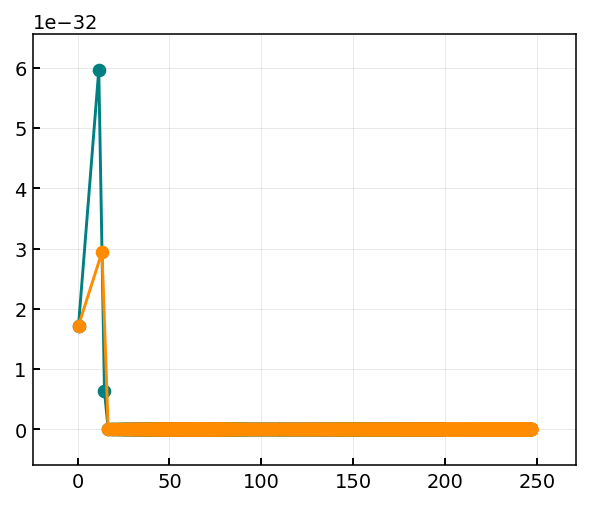

In [545]:
profiles = store_profiles["Lc"]
store = stores[study]["synthetic"]
names = list(store.keys())

# Compare last and first case only!!
case1 = DLScase(store[names[0]])
case2 = DLScase(store[names[-1]])

temp = np.linspace(0,50,100)

fig, ax = plt.subplots()

for case in [case1, case2]:
    dls = case.data
    s = case.stats
    
    Te = dls["Te"]
    Lz = [case.Lfunc(T) for T in Te]


    ax.plot(Te, Lz, marker = "o")
    # ax.plot(dls["Spar"], dls["Te"])
# ax.set_xscale("log")
# ax.set_xlim(-0.1,1)

## Find differences in Beff/Bt

0    1.988373
Name: BxBteff, dtype: float64
0    1.894054
Name: BxBteff, dtype: float64
0    1.570312
Name: BxBteff, dtype: float64
0    1.712755
Name: BxBteff, dtype: float64
0    1.360857
Name: BxBteff, dtype: float64
0    1.793011
Name: BxBteff, dtype: float64


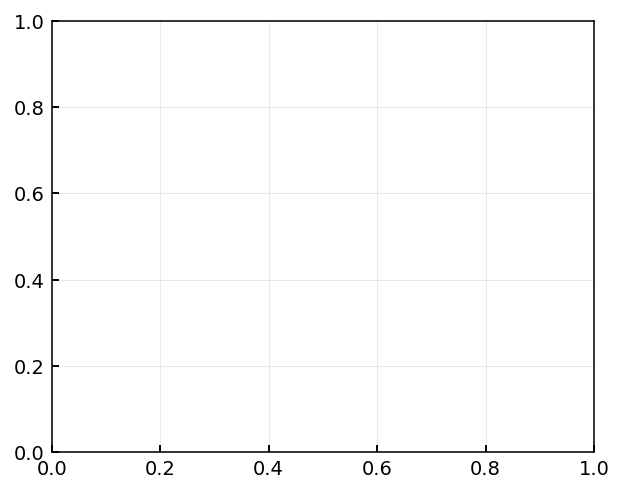

In [246]:
study = "curves_example_BxBt"

fig, ax = plt.subplots()

for curve_name in curves["example"].keys():
    
    profiles = store_profiles["bxbt"]
    store = stores[study][curve_name]
    names = list(store.keys())

    # Compare last and first case only!!
    df = get_detachment_scalings(profiles, store)
    df1 = DLScase(store[names[0]]).get_stats_dataframe()
    df2 = DLScase(store[names[-1]]).get_stats_dataframe()
    
    print(df1["BxBteff"])


# Debug

## Debug avgB
- Needed to integrate to average

,cvar,kappa0,Bf,Bx,Beff,BxBt,BxBteff,Lc,Wradial,avgB_ratio,int_qoverBsq_dt,W_Tu,W_Tu_simple,int_TLz_dt
0,3.104908e+20,2500.0,1.675803,3.351054,1.675806,1.999671,1.999667,8.385215,1.401666e+08,1.232678,7.077645,0.164516,0.341119,1.976159e+13


,cvar,kappa0,Bf,Bx,Beff,BxBt,BxBteff,Lc,Wradial,avgB_ratio,int_qoverBsq_dt,W_Tu,W_Tu_simple,int_TLz_dt
0,1.560760e+20,2500.0,0.837901,3.350812,0.837923,3.999053,3.99895,8.385215,1.401789e+08,1.39502,7.078094,0.168,0.344944,1.098828e+13


Bx              || profile: 3.352   case: 3.351
Average B       || profile: 1.868   case: 2.402
Average B ratio || profile: 1.835   case: 1.395


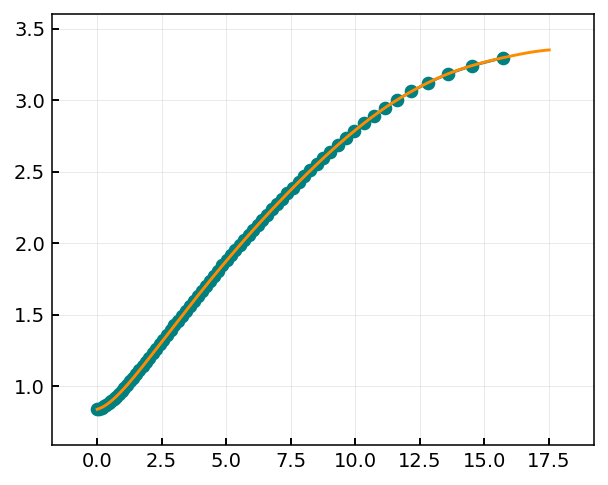

In [536]:
# Compare last and first case only!!
store = stores[study]["synthetic"]
df1 = DLScase(store[2]).get_stats_dataframe()
df2 = DLScase(store[4]).get_stats_dataframe()
# scaling = test_scalings(df1, df2, "BxBt", cumulative = True)

display(df1)
display(df2)
# display(scaling)


p = store_profiles["bxbt"][4]
case = DLScase(store[4])
dls = case.data
s = case.stats




dlsx = dls[dls["Xpoint"]==1]
case_Bx = dlsx["Btot"].iloc[0]

profile_Bx = p["Btot"][p["Xpoint"]]
profile_avgB = p["Btot"][:p["Xpoint"]].mean()
profile_avgB = sp.integrate.trapz(p["Btot"][:p["Xpoint"]], x = p["S"][:p["Xpoint"]]) / p["S"][p["Xpoint"]+1]
profile_avgB_ratio = profile_Bx/p["Btot"][:p["Xpoint"]].mean()



# case_avgB = dls.iloc[:dlsx.index[0]]["Btot"].mean()
case_avgB = sp.integrate.trapz(dls_sol["Btot"], x = dls_sol["Spar"]) / dls_sol["Spar"].iloc[-1]

case_avgB_ratio = case_Bx / case_avgB


print(f"Bx              || profile: {profile_Bx:.3f}   case: {case_Bx:.3f}")
print(f"Average B       || profile: {profile_avgB:.3f}   case: {case_avgB:.3f}")
print(f"Average B ratio || profile: {profile_avgB_ratio:.3f}   case: {case_avgB_ratio:.3f}")

fig, ax = plt.subplots()
# ax.plot(p["S"], p["Btot"], label = "Profile")
# ax.plot(dls["Spar"], dls["Btot"], label = "Case")

ax.plot(p["S"][:p["Xpoint"]], p["Btot"][:p["Xpoint"]], marker = "o", label = "Profile")
ax.plot(dls_sol["Spar"], dls_sol["Btot"], label = "Case")

# Old backup

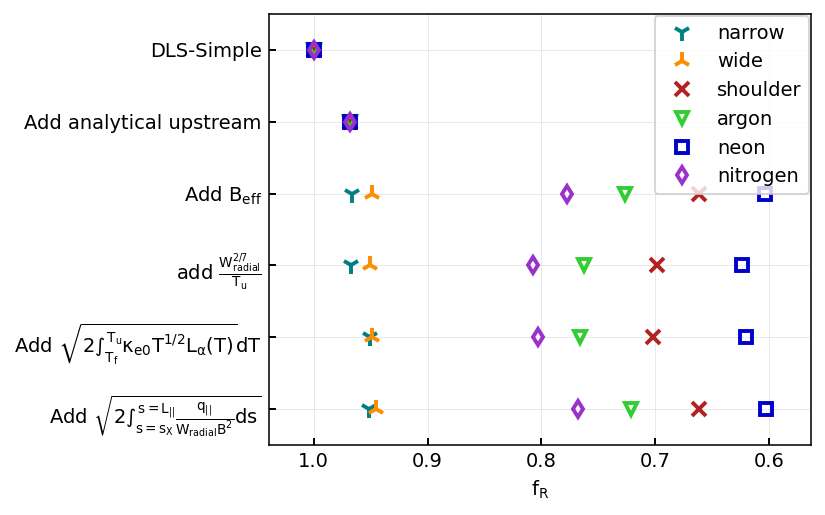

In [ ]:
scalings = pd.DataFrame()

for curve_name in stores["curves"].keys():

    profiles = store_profiles["bxbt"]
    store = stores["curves"][curve_name]

    df = get_detachment_scalings(profiles, store)

    scaling = df / df.iloc[0,:]
    out = pd.DataFrame()
    out["param"] = profiles.keys()
    out["param_rel"] = out["param"] / out["param"].iloc[0]
    out["simple"] = (df["BxBt"]/df["BxBt"][0])**(-1) * (df["L"]/df["L"][0])**(-2/7) * (df["avgB_ratio"]/df["avgB_ratio"])**(2/7)
    out["simple"] = (df["BxBt"]/df["BxBt"][0])**(-1) * (df["L"]/df["L"][0])**(-2/7) * (df["avgB_ratio"]/df["avgB_ratio"])**(2/7)
    out["simple_abovex"] = (scaling["Bf"]) * (scaling["W_Tu_simple"]) 
    out["add_Beff"] = (scaling["Btot_eff"]) * (scaling["W_Tu_simple"]) 
    out["add_W_Tu"] = (scaling["Btot_eff"]) * (scaling["W_Tu"])
    out["add_curveclip"] = (scaling["Btot_eff"]) * (scaling["W_Tu"]) * (scaling["int_TLz_dt"]) 
    out["add_upstream_rad"] = (scaling["Btot_eff"]) * (scaling["W_Tu"]) * (scaling["int_TLz_dt"]) * (scaling["int_qoverBsq_dt"])

    dflog = out.copy().drop("param", axis = 1)
    dflog["param_rel"] = np.log(dflog["param_rel"])

    for col in dflog.drop("param_rel", axis = 1).columns:
        
        dflog[col] = np.log(1/dflog[col])
        dflog[col] /= dflog["param_rel"]
        
    dflog["param_rel"] = out["param_rel"]
    dflog = dflog.iloc[1:]
    
    for col in dflog.columns:
        scalings.loc[curve_name,col] = dflog.loc[1, col]
    
scalings = scalings.drop("param_rel", axis = 1)
scalings


fig, ax = plt.subplots()

labels = dict(simple = "DLS-Simple", simple_abovex = "Add analytical upstream", add_Beff = "Add $B_{eff}$", add_W_Tu = r"add $\frac{W_{radial}^{2/7}}{T_{u}}$",
              add_curveclip = r"Add ${\sqrt{2\int^{T_{u}}_{T_{f}} \kappa_{e0} T^{1/2}  L_{\alpha}(T) }dT}$", add_upstream_rad = r"Add $\sqrt{2 \int^{s=L_{||}}_{s=s_{X}} \frac{q_{||}}{W_{radial}B^{2}}ds}$")

scalings.rename(columns = labels, inplace = True)

curve_styles = dict(
    narrow = dict(marker = "1", ms = 9, markeredgewidth = 2, markerfacecolor = "None"),
    wide = dict(marker = "2", ms = 9, markeredgewidth = 2),
    shoulder = dict(marker = "x", ms = 7, markeredgewidth = 2),
    argon = dict(marker = "v", ms = 6, markeredgewidth = 2, markerfacecolor = "None"),
    nitrogen = dict(marker = "d", ms = 6, markeredgewidth = 2, markerfacecolor = "None"),
    neon = dict(marker = "s", ms = 6, markeredgewidth = 2, markerfacecolor = "None")
)

for curve in scalings.index:
    ax.plot(scalings.loc[curve,:], scalings.columns, lw = 0, label = curve, **curve_styles[curve])
    
ax.set_xlabel(r"$f_{R}$")
ax.invert_yaxis()
ax.invert_xaxis()
ax.legend()


In [199]:
labels.values()

dict_values(['DLS-Simple', 'Add analytical upstream', 'Add B_{eff} effect', 'add $W_{radial}^{2/7}$', 'Add impact of curve clipping', 'Add impact of upstream radiation'])

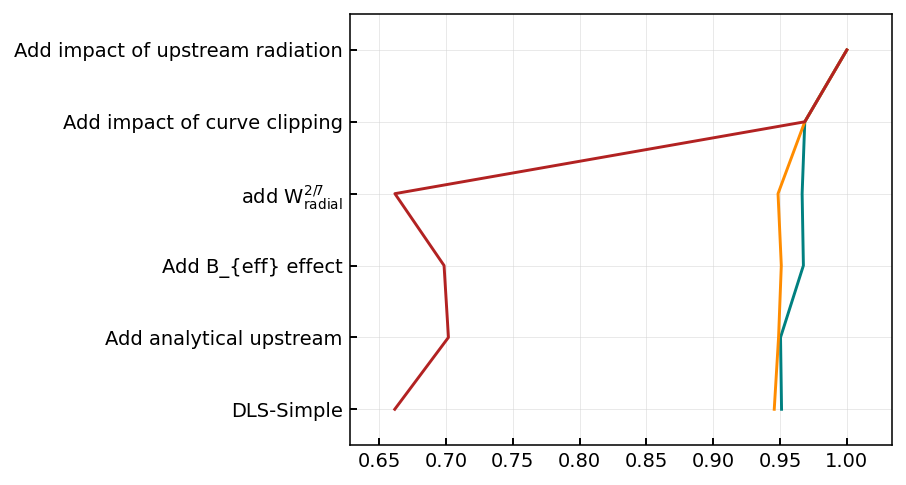

In [179]:
scalings- scalings["Beff"]

,Beff,W_Tu,curveclip,narrow,shoulder,simple,simple_abovex,upstream_rad,wide
narrow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shoulder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
profiles = store_profiles["bxbt"]
store = stores["curves"]["shoulder"]
front_dfs = [get_front_widths(profiles[x], store[x], Rcutoff = 0.9, use_prad = True) for x in profiles.keys()]
for df in front_dfs:
    display(df)

,Spol,Spol_front_end,Spol_front_start,Spol_front_width,Spol_5eV,Spar,Spar_front_end,Spar_front_start,Spar_front_width,Spar_5eV,cvar,Btot,Btot_eff,Btot_eff_old,Tu
0,0.0,0.004494,3.03529,3.030797,0.0,0.0,0.008846,17.625106,17.61626,0.0,7.481535e+19,1.675803,2.169458,1.998218,189.864804


,Spol,Spol_front_end,Spol_front_start,Spol_front_width,Spol_5eV,Spar,Spar_front_end,Spar_front_start,Spar_front_width,Spar_5eV,cvar,Btot,Btot_eff,Btot_eff_old,Tu
0,0.0,0.004494,1.890153,1.885659,0.0,0.0,0.008846,6.018226,6.00938,0.0,4.745848e+19,0.837901,1.341758,1.301639,190.566164


In [159]:
profiles.keys()

dict_keys([2, 4])

In [158]:
store.keys()

dict_keys([2, 4])

In [148]:
changes = scalings.copy()

for i, col in enumerate(changes.columns):
    if i > 0:
        previous_col = changes.columns[i-1]
        print(col, previous_col)
        
        changes[col] = changes[col] - changes[previous_col]
    
changes

simple_abovex simple
add_Beff simple_abovex
add_W_Tu add_Beff
add_curveclip add_W_Tu
add_upstream_rad add_curveclip


,simple,simple_abovex,add_Beff,add_W_Tu,add_curveclip,add_upstream_rad
narrow,1.0,-0.03149,0.998023,-0.030546,0.980912,-0.029794
wide,1.0,-0.03149,0.979986,-0.029047,0.977932,-0.032272
shoulder,1.0,-0.03149,0.693209,0.005311,0.696484,-0.034862


In [ ]:
fig, ax = plt.subplots()

weights = {}

for effect in scalings.drop("param_rel", axis = 1).columns:


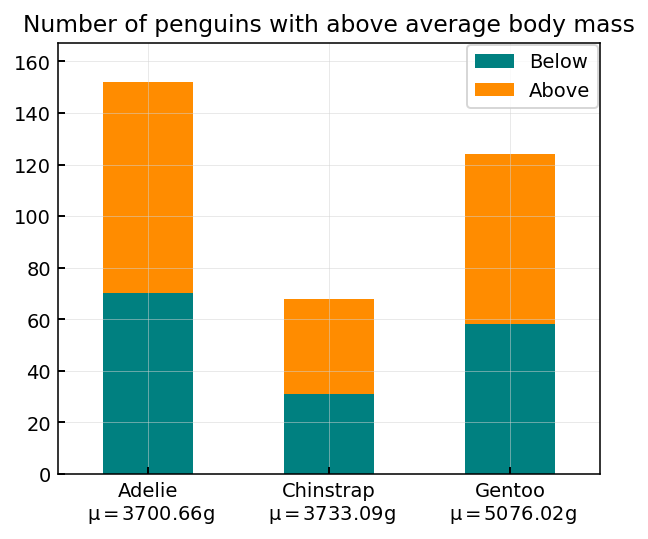

In [143]:
species = (
    "Adelie\n $\\mu=$3700.66g",
    "Chinstrap\n $\\mu=$3733.09g",
    "Gentoo\n $\\mu=5076.02g$",
)
weight_counts = {
    "Below": np.array([70, 31, 58]),
    "Above": np.array([82, 37, 66]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Number of penguins with above average body mass")
ax.legend(loc="upper right")

In [139]:
scalings.loc["narrow"] = dflog.iloc[0,:]
scalings

ValueError: Must have equal len keys and value when setting with an iterable